In [ ]:
# Step 1: Create Synthetic Data
import numpy as np
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope)
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [ ]:
# Step 2: Create Sliding Windows on the data series
import torch

def create_sliding_windows_with_target(data, window_size, shift=1):
    """
    Creates sliding windows from a sequence, splitting each window into features and target.

    Args:
        data: Input sequence (can be list, numpy array, or torch tensor)
        window_size: Size of each window
        shift: Number of elements to shift each window (stride)

    Returns:
        tuple: (features, targets) where:
            - features is a tensor of shape (num_windows, window_size-1)
            - targets is a tensor of shape (num_windows, 1)
    """
    # Convert input to tensor if it isn't already
    if not isinstance(data, torch.Tensor):
        data = torch.tensor(data, dtype=torch.float32)

    # Create windows using unfold
    windows = data.unfold(0, window_size, shift)

    # Split each window into features (all but last element) and target (last element)
    features = windows[:, :-1]  # All elements except the last
    targets = windows[:, -1:]   # Just the last element

    return features, targets


Original series length: 1461
Total number of windows: 1432
Training windows: 971
Validation windows: 461

Example Training Batch:
Batch shape - Features: torch.Size([32, 29]), Targets: torch.Size([32, 1])

Example Validation Batch:
Batch shape - Features: torch.Size([32, 29]), Targets: torch.Size([32, 1])


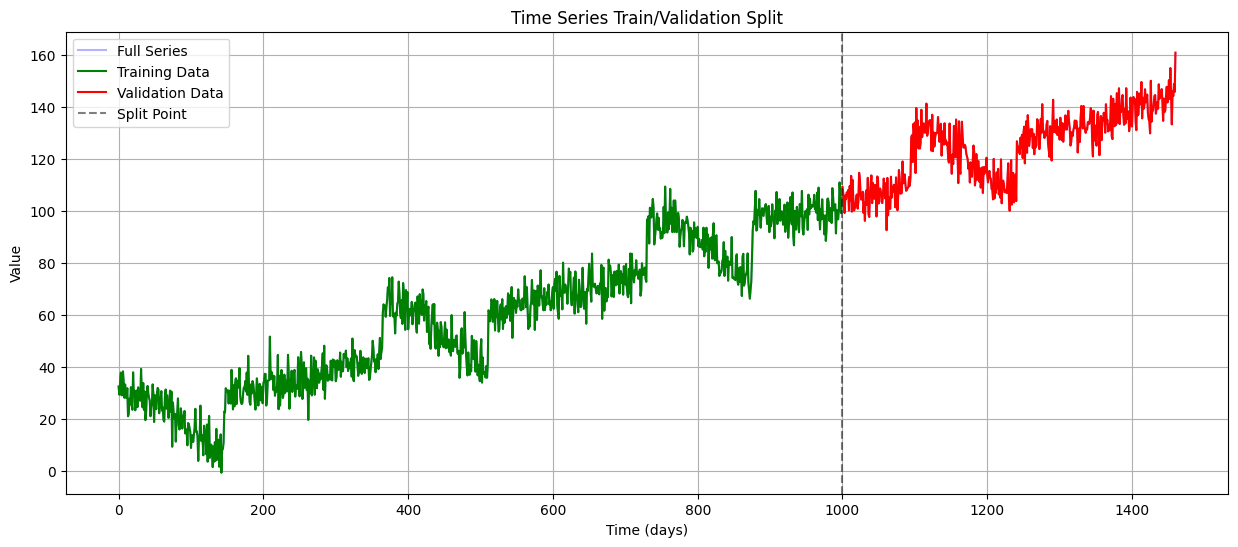

In [ ]:
# Step 3: Turn this data into a dataset, and split it into trainng and validation slices
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
import numpy as np

# First create the full windowed dataset
series_tensor = torch.tensor(series, dtype=torch.float32)
window_size = 30
features, targets = create_sliding_windows_with_target(series_tensor, window_size=window_size, shift=1)

# Create the full dataset
full_dataset = TensorDataset(features, targets)

# Calculate split indices
# Note: Since we're using windows, we need to account for the overlap
# The index 1000 in the original series will correspond to a different window index
train_size = 1000 - window_size + 1  # Adjust for window overlap
total_windows = len(full_dataset)
train_indices = list(range(train_size))
val_indices = list(range(train_size, total_windows))

# Create training and validation datasets using Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print information about the splits
print(f"Original series length: {len(series)}")
print(f"Total number of windows: {total_windows}")
print(f"Training windows: {len(train_dataset)}")
print(f"Validation windows: {len(val_dataset)}")

# Show example batch from each
print("\nExample Training Batch:")
train_features, train_targets = next(iter(train_loader))
print(f"Batch shape - Features: {train_features.shape}, Targets: {train_targets.shape}")

print("\nExample Validation Batch:")
val_features, val_targets = next(iter(val_loader))
print(f"Batch shape - Features: {val_features.shape}, Targets: {val_targets.shape}")

# Visualize the split point
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(range(len(series)), series, 'b-', label='Full Series', alpha=0.3)
plt.plot(range(1000), series[:1000], 'g-', label='Training Data')
plt.plot(range(1000, len(series)), series[1000:], 'r-', label='Validation Data')
plt.axvline(x=1000, color='k', linestyle='--', alpha=0.5, label='Split Point')
plt.title('Time Series Train/Validation Split')
plt.xlabel('Time (days)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Train loader batch shape:
Features shape: torch.Size([32, 29])
Targets shape: torch.Size([32, 1])
Using input size: 29
Epoch [10/1000], Train Loss: 49.001907, Val Loss: 42.834764
Epoch [20/1000], Train Loss: 46.787220, Val Loss: 42.510158
Epoch [30/1000], Train Loss: 43.539269, Val Loss: 39.918324
Epoch [40/1000], Train Loss: 39.230143, Val Loss: 52.416530
Epoch [50/1000], Train Loss: 36.172639, Val Loss: 35.942597
Epoch [60/1000], Train Loss: 32.832556, Val Loss: 38.457588
Epoch [70/1000], Train Loss: 31.989660, Val Loss: 37.894261
Epoch [80/1000], Train Loss: 31.713073, Val Loss: 33.511011
Epoch [90/1000], Train Loss: 31.825925, Val Loss: 33.387900
Epoch [100/1000], Train Loss: 32.406881, Val Loss: 33.749534
Epoch [110/1000], Train Loss: 31.704221, Val Loss: 34.752169
Epoch [120/1000], Train Loss: 30.172355, Val Loss: 33.637324
Epoch [130/1000], Train Loss: 31.541116, Val Loss: 34.053109
Epoch [140/1000], Train Loss: 30.453200, Val Loss: 36.130592
Epoch [150/1000], Train Loss: 30.275

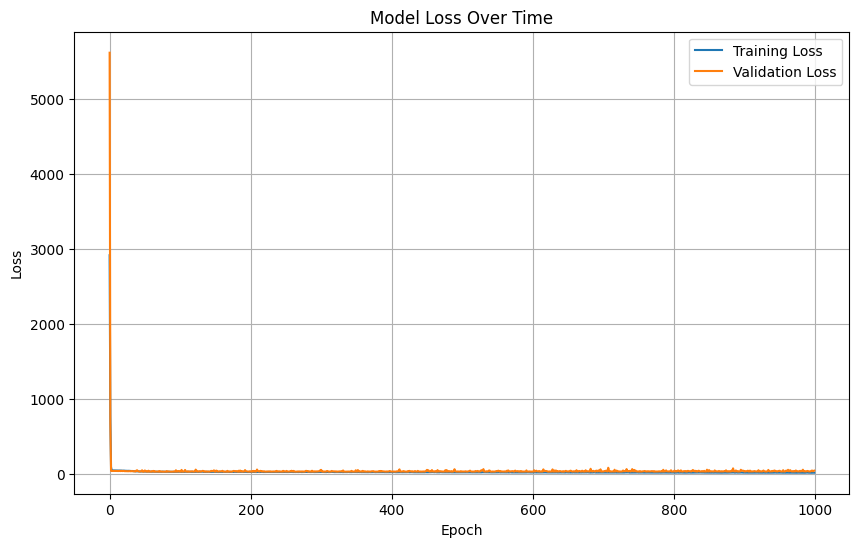

Train predictions shape: (971, 1)
Validation predictions shape: (461, 1)


In [ ]:
# Step 4 Create and train a 1D
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1,
                              out_channels=128,
                              kernel_size=3,
                              padding=1)

        conv_output_size = input_size  # Same padding maintains input size

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(128 * conv_output_size, 28)
        self.dense2 = nn.Linear(28, 10)
        self.dense3 = nn.Linear(10, 1)

    def forward(self, x):
        # Transpose input from [batch_size, sequence_length] to [batch_size, 1, sequence_length]
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        elif len(x.shape) == 3 and x.shape[1] != 1:
            x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.dense3(x)
        return x

def train_model(model, train_loader, val_loader, num_epochs=1000, learning_rate=1e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}')

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

def predict(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            batch_predictions = model(inputs)
            predictions.append(batch_predictions.cpu().numpy())

    return np.concatenate(predictions)

# Example usage:
if __name__ == "__main__":
    # Debug prints
    print("Train loader batch shape:")
    sample_batch = next(iter(train_loader))
    print("Features shape:", sample_batch[0].shape)
    print("Targets shape:", sample_batch[1].shape)

    # Initialize model with sequence length
    input_size = sample_batch[0].shape[1]  # Get sequence length from data
    print(f"Using input size: {input_size}")
    model = CNN1D(input_size)

    # Train the model
    model = train_model(model, train_loader, val_loader)

    # Make predictions
    train_predictions = predict(model, train_loader)
    val_predictions = predict(model, val_loader)

    print("Train predictions shape:", train_predictions.shape)
    print("Validation predictions shape:", val_predictions.shape)

In [ ]:
# Step 5 - Do predictions
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

def evaluate_predictions(model, loader):
    """Generate predictions and calculate metrics"""
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    predictions = np.array(all_predictions)
    targets = np.array(all_targets)


    # Calculate metrics
    mae = mean_absolute_error(targets, predictions)

    return predictions, targets, mae

def plot_predictions(val_pred, val_true):
    """Plot the predictions against actual values"""
    plt.figure(figsize=(15, 6))


    # Plot validation data
    offset = len(val_true)
    plt.plot(range(offset, offset + len(val_true)), val_true, 'b-', label='Validation Actual')
    plt.plot(range(offset, offset + len(val_pred)), val_pred, 'r-', label='Validation Predicted')



    plt.title('Time Series Prediction vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# After training your model:
# Generate predictions
val_predictions, val_targets, val_mae = evaluate_predictions(model, val_loader)

# Print metrics
print(f"Validation MAE: {val_mae:.4f}")

# Plot results
plot_predictions(val_predictions, val_targets)


NameError: name 'model' is not defined

# Neural Architecture Search
## Needs steps 1, 2, and 3 pre-run, as well as the 'evaluate_predictions' function in step 5 to be executed


Using device: cpu
Total configurations to try: 48

Trying configuration 1/48:
{'num_conv_layers': 1, 'conv_channels': [32], 'kernel_size': 3, 'dense_sizes': [16], 'learning_rate': 0.001}
Model architecture:
Input size: 29
Conv channels: [32]
Flattened size: 928
Dense sizes: [16]
Epoch 0: Train Loss = 678.6905, Val Loss = 173.8189
Epoch 10: Train Loss = 42.5765, Val Loss = 38.6861
Epoch 20: Train Loss = 35.3378, Val Loss = 34.2731
Epoch 30: Train Loss = 33.4559, Val Loss = 33.7960
Epoch 40: Train Loss = 35.7906, Val Loss = 34.0338
Early stopping triggered after 45 epochs
New best MAE: 4.5310

Trying configuration 2/48:
{'num_conv_layers': 1, 'conv_channels': [32], 'kernel_size': 3, 'dense_sizes': [16], 'learning_rate': 0.0001}
Model architecture:
Input size: 29
Conv channels: [32]
Flattened size: 928
Dense sizes: [16]
Epoch 0: Train Loss = 2722.8093, Val Loss = 5074.3318
Epoch 10: Train Loss = 51.3133, Val Loss = 44.9227
Epoch 20: Train Loss = 50.0039, Val Loss = 43.8794
Epoch 30: Train

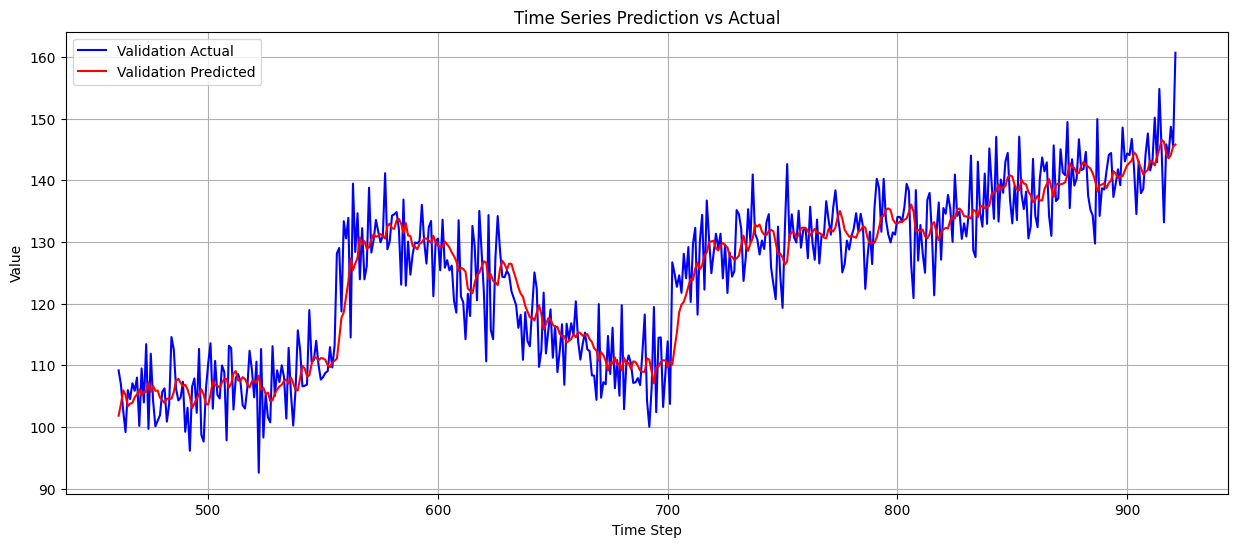

In [ ]:
import torch
import torch.nn as nn
from itertools import product
from copy import deepcopy
import time
from torch.utils.data import DataLoader

class CNN1D(nn.Module):
    def __init__(self, input_size, num_conv_layers, conv_channels, kernel_size, dense_sizes):
        super(CNN1D, self).__init__()

        # Conv layers
        self.conv_layers = nn.ModuleList()
        in_channels = 1
        curr_size = input_size

        for i in range(num_conv_layers):
            self.conv_layers.append(nn.Conv1d(
                in_channels=in_channels,
                out_channels=conv_channels[i],
                kernel_size=kernel_size,
                padding='same'  # This maintains the sequence length
            ))
            self.conv_layers.append(nn.ReLU())
            in_channels = conv_channels[i]

        # Calculate flattened size after convolutions
        # Since we use 'same' padding, the sequence length remains input_size
        # The channels become the last conv layer's out_channels
        flattened_size = input_size * conv_channels[-1]

        # Dense layers
        self.dense_layers = nn.ModuleList()
        prev_size = flattened_size

        for size in dense_sizes:
            self.dense_layers.append(nn.Linear(prev_size, size))
            self.dense_layers.append(nn.ReLU())
            prev_size = size

        # Final output layer
        self.output_layer = nn.Linear(prev_size, 1)

        # Flatten layer
        self.flatten = nn.Flatten()

        print(f"Model architecture:")
        print(f"Input size: {input_size}")
        print(f"Conv channels: {conv_channels}")
        print(f"Flattened size: {flattened_size}")
        print(f"Dense sizes: {dense_sizes}")

    def forward(self, x):
        # Print shape at each step for debugging
        # print(f"Input shape: {x.shape}")

        # Reshape input if needed
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        elif len(x.shape) == 3 and x.shape[1] != 1:
            x = x.transpose(1, 2)

        # print(f"After reshape: {x.shape}")

        # Conv layers
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            # print(f"After conv layer {i//2}: {x.shape}")

        # Flatten
        x = self.flatten(x)
        # print(f"After flatten: {x.shape}")

        # Dense layers
        for i, layer in enumerate(self.dense_layers):
            x = layer(x)
            # print(f"After dense layer {i//2}: {x.shape}")

        # Output layer
        x = self.output_layer(x)
        # print(f"Final output: {x.shape}")
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, early_stopping_patience=5):
    """Train the model with early stopping"""
    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        val_loss /= len(val_loader)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch} epochs')
            break

    return best_model, best_val_loss

def neural_architecture_search(train_loader, val_loader, input_size=29):
    """Perform neural architecture search for CNN architecture"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the search space
    num_conv_layers_options = [1, 2]  # Reduced for initial testing
    conv_channels_options = [
        [32],
        [64],
        [32, 16],
        [64, 32],
    ]
    kernel_sizes = [3, 5]
    dense_sizes_options = [
        [16],
        [32, 16],
        [64, 32],
    ]
    learning_rates = [0.001, 0.0001]

    best_mae = float('inf')
    best_config = None
    best_model = None
    results = []

    # Generate valid configurations
    configurations = []
    for num_conv_layers in num_conv_layers_options:
        for channels in conv_channels_options:
            if len(channels) == num_conv_layers:  # Only use channel configs that match layer count
                for kernel_size in kernel_sizes:
                    for dense_sizes in dense_sizes_options:
                        for lr in learning_rates:
                            configurations.append({
                                'num_conv_layers': num_conv_layers,
                                'conv_channels': channels,
                                'kernel_size': kernel_size,
                                'dense_sizes': dense_sizes,
                                'learning_rate': lr
                            })

    print(f"Total configurations to try: {len(configurations)}")
    start_time = time.time()

    for idx, config in enumerate(configurations):
        print(f"\nTrying configuration {idx + 1}/{len(configurations)}:")
        print(config)

        try:
            model = CNN1D(
                input_size=input_size,
                num_conv_layers=config['num_conv_layers'],
                conv_channels=config['conv_channels'],
                kernel_size=config['kernel_size'],
                dense_sizes=config['dense_sizes']
            ).to(device)

            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

            trained_model, val_loss = train_model(
                model, train_loader, val_loader, criterion, optimizer,
                epochs=100, device=device, early_stopping_patience=10
            )

            # Evaluate model
            val_predictions, val_targets, val_mae = evaluate_predictions(trained_model, val_loader)

            config_results = {
                **config,
                'val_mae': val_mae,
                'val_loss': val_loss
            }
            results.append(config_results)

            if val_mae < best_mae:
                best_mae = val_mae
                best_config = config_results
                best_model = deepcopy(trained_model)
                print(f"New best MAE: {val_mae:.4f}")

        except Exception as e:
            print(f"Error with configuration {idx + 1}: {str(e)}")
            continue

    total_time = time.time() - start_time
    results.sort(key=lambda x: x['val_mae'])

    return best_model, results, total_time

def display_nas_results(results, total_time):
    """Display the results of the neural architecture search"""
    print("\nNeural Architecture Search Results")
    print(f"Total search time: {total_time:.2f} seconds")
    print("\nTop 5 Configurations:")

    for i, config in enumerate(results[:5]):
        print(f"\n{i+1}. Configuration:")
        print(f"   Number of Conv Layers: {config['num_conv_layers']}")
        print(f"   Conv Channels: {config['conv_channels']}")
        print(f"   Kernel Size: {config['kernel_size']}")
        print(f"   Dense Sizes: {config['dense_sizes']}")
        print(f"   Learning Rate: {config['learning_rate']}")
        print(f"   Validation MAE: {config['val_mae']:.4f}")
        print(f"   Validation Loss: {config['val_loss']:.4f}")

# Run the search
best_model, results, total_time = neural_architecture_search(train_loader, val_loader)

# Display results
display_nas_results(results, total_time)

# Generate and plot predictions with the best model
val_predictions, val_targets, val_mae = evaluate_predictions(best_model, val_loader)
plot_predictions(val_predictions, val_targets)

In [ ]:
# Hard coding a network with the 'winning' parameters:
# Step 4 Create and train a 1D CNN
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class CNN1D(nn.Module):
    def __init__(self, input_size):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1,
                              out_channels=128,
                              kernel_size=3,
                              padding=1)

        conv_output_size = input_size  # Same padding maintains input size

        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(128 * conv_output_size, 28)
        self.dense2 = nn.Linear(28, 10)
        self.dense3 = nn.Linear(10, 1)

    def forward(self, x):
        # Transpose input from [batch_size, sequence_length] to [batch_size, 1, sequence_length]
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        elif len(x.shape) == 3 and x.shape[1] != 1:
            x = x.transpose(1, 2)

        x = self.relu(self.conv1(x))
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.dense3(x)
        return x

def train_model(model, train_loader, val_loader, num_epochs=1000, learning_rate=1e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}')

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

def predict(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            batch_predictions = model(inputs)
            predictions.append(batch_predictions.cpu().numpy())

    return np.concatenate(predictions)

# Example usage:
if __name__ == "__main__":
    # Debug prints
    print("Train loader batch shape:")
    sample_batch = next(iter(train_loader))
    print("Features shape:", sample_batch[0].shape)
    print("Targets shape:", sample_batch[1].shape)

    # Initialize model with sequence length
    input_size = sample_batch[0].shape[1]  # Get sequence length from data
    print(f"Using input size: {input_size}")
    model = CNN1D(input_size)

    # Train the model
    model = train_model(model, train_loader, val_loader)

    # Make predictions
    train_predictions = predict(model, train_loader)
    val_predictions = predict(model, val_loader)

    print("Train predictions shape:", train_predictions.shape)
    print("Validation predictions shape:", val_predictions.shape)

In [ ]:
import torch
import torch.nn as nn

class BestCNN1D(nn.Module):
    def __init__(self, input_size=29):
        super(BestCNN1D, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv1d(
            in_channels=1,
            out_channels=64,
            kernel_size=5,
            padding='same'
        )
        self.relu1 = nn.ReLU()

        # Second Convolutional Layer
        self.conv2 = nn.Conv1d(
            in_channels=64,
            out_channels=32,
            kernel_size=5,
            padding='same'
        )
        self.relu2 = nn.ReLU()

        # Flatten layer
        self.flatten = nn.Flatten()

        # Calculate flattened size (input_size * last_conv_channels)
        flattened_size = input_size * 32

        # Dense layers
        self.dense1 = nn.Linear(flattened_size, 64)
        self.relu3 = nn.ReLU()
        self.dense2 = nn.Linear(64, 32)
        self.relu4 = nn.ReLU()

        # Output layer
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        # Reshape input if needed
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        elif len(x.shape) == 3 and x.shape[1] != 1:
            x = x.transpose(1, 2)

        # Convolutional layers
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))

        # Flatten
        x = self.flatten(x)

        # Dense layers
        x = self.relu3(self.dense1(x))
        x = self.relu4(self.dense2(x))

        # Output
        x = self.output(x)
        return x

# Usage example:

# Initialize model
model = BestCNN1D()

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize optimizer with the best learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Loss function
criterion = nn.MSELoss()

num_epochs = 300
# Train the model
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {loss:.6f}, ')



Epoch [10/300], Train Loss: 39.836365, 
Epoch [20/300], Train Loss: 32.371822, 
Epoch [30/300], Train Loss: 39.047825, 
Epoch [40/300], Train Loss: 79.511925, 
Epoch [50/300], Train Loss: 30.350197, 
Epoch [60/300], Train Loss: 60.324718, 
Epoch [70/300], Train Loss: 17.105558, 
Epoch [80/300], Train Loss: 44.542542, 
Epoch [90/300], Train Loss: 31.013988, 
Epoch [100/300], Train Loss: 14.941776, 
Epoch [110/300], Train Loss: 14.934296, 
Epoch [120/300], Train Loss: 14.721520, 
Epoch [130/300], Train Loss: 32.403133, 
Epoch [140/300], Train Loss: 19.219929, 
Epoch [150/300], Train Loss: 22.576805, 
Epoch [160/300], Train Loss: 57.011967, 
Epoch [170/300], Train Loss: 16.975269, 
Epoch [180/300], Train Loss: 42.619358, 
Epoch [190/300], Train Loss: 28.211145, 
Epoch [200/300], Train Loss: 25.658533, 
Epoch [210/300], Train Loss: 38.611446, 
Epoch [220/300], Train Loss: 24.976402, 
Epoch [230/300], Train Loss: 58.016735, 
Epoch [240/300], Train Loss: 69.249268, 
Epoch [250/300], Train Lo

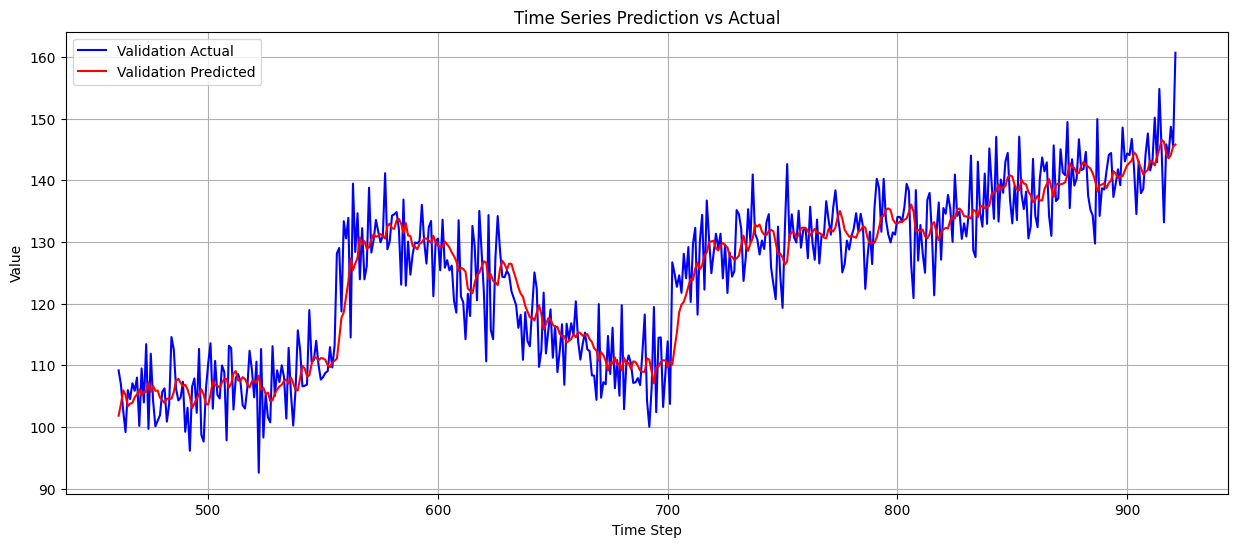

4.443853


In [ ]:
val_predictions, val_targets, val_mae = evaluate_predictions(best_model, val_loader)
plot_predictions(val_predictions, val_targets)
print(val_mae)